# Notebook de cliente / Experimentação do modelo

In [1]:
from datasets import load_dataset
from model import NERClassifier
from preprocess_dataset import NERDataset 
from trainner import Trainner
from transformers import BertTokenizer
from preprocess_dataset import remove_empty_entries

import torch

## Setups

In [2]:

CHECKPOINT = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(CHECKPOINT)
data = "lener_br"
dataset = load_dataset(data)

dataset = remove_empty_entries(dataset)

Reusing dataset lener_br (/home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382)
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-5e59bc59f25f3d7f.arrow
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-8d0457760cd67ee6.arrow
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-74e841c1c151996a.arrow


In [3]:
MAX_LEN = 256

In [4]:
pytorch_dataset_train = NERDataset(data=dataset['train'], max_len=MAX_LEN, tokenizer=tokenizer)
teste = pytorch_dataset_train[0]
n_labels = 13 #TODO: por enquanto hardcodado 
model = NERClassifier(n_labels=n_labels, checkpoint=CHECKPOINT)
input_ids = teste['input_ids']
attention_mask = teste['attention_mask']
labels = teste['targets']

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

## Explorando um pouco o dataset

In [5]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'ner_tags', 'tokens'],
        num_rows: 7827
    })
    validation: Dataset({
        features: ['id', 'ner_tags', 'tokens'],
        num_rows: 1176
    })
    test: Dataset({
        features: ['id', 'ner_tags', 'tokens'],
        num_rows: 1389
    })
})

In [7]:
# dataset = remove_empty_entries(dataset)

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'ner_tags', 'tokens'],
        num_rows: 7827
    })
    validation: Dataset({
        features: ['id', 'ner_tags', 'tokens'],
        num_rows: 1176
    })
    test: Dataset({
        features: ['id', 'ner_tags', 'tokens'],
        num_rows: 1389
    })
})

In [9]:
max_vals = [torch.max(val['targets']) for val in pytorch_dataset_train]

In [10]:
interval = (min(max_vals).item(), max(max_vals).item())

In [11]:
interval

(0, 12)

In [12]:
saida = model(input_ids, attention_mask, labels=labels)
print(saida)

TokenClassifierOutput(loss=tensor(2.5955, grad_fn=<NllLossBackward>), logits=tensor([[[-0.0260,  0.2948,  0.0579,  ..., -0.1163,  0.1478, -0.4721],
         [ 0.6680, -0.1135, -0.7813,  ...,  0.0356,  0.1786, -0.1851],
         [ 0.0152, -0.5089,  0.2501,  ..., -0.1331,  0.2662,  0.0662],
         ...,
         [ 0.3990, -0.0729, -0.0771,  ...,  0.3480, -0.0042, -0.0987],
         [ 0.0696,  0.3867, -0.1915,  ...,  0.2513,  0.1726, -0.1915],
         [ 0.2994,  0.0285, -0.2428,  ...,  0.1533,  0.0125, -0.2019]]],
       grad_fn=<AddBackward0>), hidden_states=None, attentions=None)


## Testando o DataLoader

In [13]:
from torch.utils.data import DataLoader

In [14]:
batch_size = 8

In [15]:
pytorch_dataset_train

In [16]:
teste = iter(DataLoader(pytorch_dataset_train ,batch_size=batch_size))

In [17]:
mini_batch = next(teste)

----------------------------------------

## Testando passar um minibatch ao modelo

In [18]:
print(mini_batch)

{'id': tensor([0, 1, 2, 3, 4, 5, 6, 7]), 'input_ids': tensor([[[  192,  7463,  8427,  ...,     0,     0,     0]],

        [[  118,   231,  1328,  ...,     0,     0,     0]],

        [[  118,  9633,   214,  ...,     0,     0,     0]],

        ...,

        [[  354,   119,   189,  ...,     0,     0,     0]],

        [[  257,  5476, 15289,  ...,     0,     0,     0]],

        [[  290,   119,     0,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 0,  ..., 0, 0, 0]]]), 'targets': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 9,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])}


In [19]:
ids = mini_batch['input_ids'].squeeze().to("cuda", dtype = torch.long) # Remove a dimensão 1 ali do meio, talvez funcione?
att = mini_batch['attention_mask'].to("cuda", dtype = torch.long)
targets = mini_batch['targets'].to("cuda", dtype = torch.long)

In [20]:
print(ids.shape)

torch.Size([8, 256])


In [21]:
#model = model.to("cuda")

In [22]:
outs = model(ids, att, labels=targets)

In [23]:
outs

TokenClassifierOutput(loss=tensor(2.6489, device='cuda:0', grad_fn=<NllLossBackward>), logits=tensor([[[-0.0260,  0.2949,  0.0579,  ..., -0.1163,  0.1478, -0.4721],
         [ 0.6680, -0.1135, -0.7813,  ...,  0.0356,  0.1786, -0.1851],
         [ 0.0152, -0.5089,  0.2501,  ..., -0.1331,  0.2662,  0.0662],
         ...,
         [ 0.3990, -0.0729, -0.0771,  ...,  0.3480, -0.0042, -0.0987],
         [ 0.0696,  0.3867, -0.1915,  ...,  0.2513,  0.1726, -0.1915],
         [ 0.2994,  0.0285, -0.2428,  ...,  0.1533,  0.0125, -0.2019]],

        [[-0.4853,  0.0252,  0.2412,  ...,  0.0554, -0.1104, -0.0533],
         [-0.2360, -0.4291,  0.1323,  ..., -0.8141,  0.1200,  0.3650],
         [-0.1512,  0.0567,  0.4187,  ...,  0.1329, -0.0488,  0.5025],
         ...,
         [ 0.0616, -0.0823,  0.1395,  ..., -0.2458,  0.3532, -0.0763],
         [ 0.1740, -0.2248,  0.4350,  ..., -0.3108,  0.2360, -0.3410],
         [ 0.1605, -0.2938,  0.4327,  ..., -0.4034,  0.3444, -0.2212]],

        [[-0.5247,  0.

## Treinando o modelo

Usando parametros padrão por enquanto só pra ver se ta tudo indo certindo

In [24]:
from trainner import Trainner, create_data_loader
from transformers import AdamW

### Parametros


* batch sizes: 8, 16, 32, 64, 128
* learning rates: 3e-4, 1e-4, 5e-5, 3e-5

Do paper do BERT. Vou colocar num_workers = 4 por enquanto.


Uma melhoria é esconder o data_loader de clientes. Isso é detalhe de implementaçãõ, ou deveria estar na classe NERDataset

In [25]:
optimizer = AdamW(model.parameters(), lr=3e-4, correct_bias=False)

In [26]:
len(pytorch_dataset_train)

7827

In [27]:
loader = DataLoader(pytorch_dataset_train, batch_size=8)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
next(model.parameters()).is_cuda

True

In [30]:
tr = Trainner(device, loader, model, optimizer)

In [31]:
losses, media = tr._train_epoch()

tensor(2.6748, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6049, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(7.2815, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1112, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9963, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4633, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2077, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9723, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3948, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4448, device='cuda:0', grad_fn=<NllLossBackward>)
Bati o limite, chega!


In [32]:
losses

[2.6747524738311768,
 0.604868471622467,
 7.281510353088379,
 0.11121179163455963,
 0.9962637424468994,
 0.4632624089717865,
 0.20766881108283997,
 0.9722746014595032,
 0.39484304189682007,
 0.4448015093803406]

In [35]:
from matplotlib import pyplot as plt

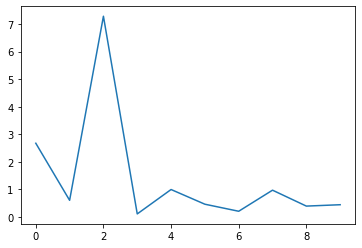

In [36]:
plt.plot(losses)